Objetivo: Los estudiantes deberán participar en una competencia de Kaggle, realizar un análisis completo del dataset, entrenar y evaluar al menos cinco modelos diferentes, y realizar un benchmark para comparar su rendimiento. El resultado final debe ser subido a GitHub.

#### DATA Seleccionada Titanic: Machine Learning from Disaster de clasificación

In [197]:
# Carga de bibliotecas
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import randint, uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
# biblioteca google.
from google.colab import drive
# conecta colab con drive.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
path ="/content/drive/MyDrive/CLASE MACHINE LEARNING/DATA_CORES/train.csv"
df = pd.read_csv(path)

In [200]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### A simple vista en cabin se distinguen 3 nulos.

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Segun la información contiene 12 columnas, con 891 entradas y 2 columnas tipo de dato float64, 1 object y 1 int64.
* se muestra que columna age tiene valores faltantes.
* se muestra que columna cabin tiene valores faltantes.
* se muestra que columna Embarked tiene valores faltantes.

In [202]:
df.columns = df.columns.str.lower().str.strip()

In [203]:
# Se estudia la estadistica de muestra con sus caracteristicas numericas
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
passengerid,891.0,446.00,257.35,1.00,223.50,446.00,668.5,891.00
survived,891.0,0.38,0.49,0.00,0.00,0.00,1.0,1.00
pclass,891.0,2.31,0.84,1.00,2.00,3.00,3.0,3.00
age,714.0,29.70,14.53,0.42,20.12,28.00,38.0,80.00
sibsp,891.0,0.52,1.10,0.00,0.00,0.00,1.0,8.00
parch,891.0,0.38,0.81,0.00,0.00,0.00,0.0,6.00
fare,891.0,32.20,49.69,0.00,7.91,14.45,31.0,512.33


#### Se muestra que la columna sibsp tiene valores 0 en su percentiles 25 y 50, con un máximo de 8.
#### Se muestra que la columna faret tiene un máximo de 512 alejado del percentil 75 que es 31.0.

In [204]:
# Se verifica duplicados
df.duplicated().sum()

np.int64(0)

In [205]:
df[df["age"].isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [206]:
df["age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

##### Se verifica que la columna age tiene valores decimales, se supone que son meses por cumplir año.

In [207]:
df["age"].isna().sum()

np.int64(177)

In [208]:
# como son 177 valores con nulos, se imputan por el premedio de la columna
age_mean = df.groupby(["sex", "pclass"])["age"].transform("mean")
df["age"] = df["age"].fillna(age_mean)

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          891 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [210]:
df[df["cabin"].isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,26.507589,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.750000,1,2,W./C. 6607,23.4500,NaN,S


In [211]:
df["cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [212]:
df.groupby(["sex", "pclass"])["cabin"].value_counts()

sex     pclass  cabin          
female  1       B18                2
                B28                2
                B35                2
                B5                 2
                B57 B59 B63 B66    2
                                  ..
male    3       F G73              2
                E10                1
                E121               1
                F G63              1
                F38                1
Name: count, Length: 171, dtype: int64

In [213]:
df["cabin"].isna().sum()

np.int64(687)

#### SE verifica que columna cabin tiene 687 nulos de 891, por lo tanto de decide eliminar la columna.

In [214]:
# Se elimina columna cabin
df.drop('cabin', inplace=True, axis=1)

In [215]:
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          891 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [217]:
df[df["embarked"].isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [218]:
df["embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [219]:
# A valores nulos se asigna la moda de mujeres de primera clase
moda = df[(df["sex"] == 'female') & (df["pclass"] == 1)]["embarked"].mode()[0]
df.loc[df['embarked'].isna(),'embarked'] = moda

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          891 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [221]:
df["passengerid"].value_counts()

,count
passengerid,
891,1
1,1
2,1
3,1
4,1
...,...
16,1
15,1
14,1


In [222]:
# Se verifica columna survived
df["survived"].unique()

array([0, 1])

In [223]:
# Se verifica columna pclass
df["pclass"].unique()

array([3, 1, 2])

In [224]:
# Se verifica columna name
df["name"].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [225]:
# Se verifica columna sex
df["sex"].unique()

array(['male', 'female'], dtype=object)

In [226]:
# Se verifica columna age
df["age"].value_counts().round(2)

,count
age,
26.507589,94
21.750000,42
24.000000,30
22.000000,27
18.000000,26
...,...
24.500000,1
0.670000,1
0.420000,1


In [227]:
# Se verifica  columna sibsp
df["sibsp"].value_counts()

,count
sibsp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


In [228]:
# Se verifica  columna parch
df["parch"].value_counts()

,count
parch,
0,678
1,118
2,80
5,5
3,5
4,4
6,1


In [229]:
# Se verifica columna ticket
df["ticket"].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [230]:
# Se verifica columna fare
df["fare"].value_counts()

,count
fare,
8.0500,43
13.0000,42
7.8958,38
7.7500,34
26.0000,31
...,...
13.8583,1
50.4958,1
5.0000,1


In [231]:
# Se verifica columna embarked
df["embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

#### Visualizaciones para entender la distribución de las variables y sus relaciones.

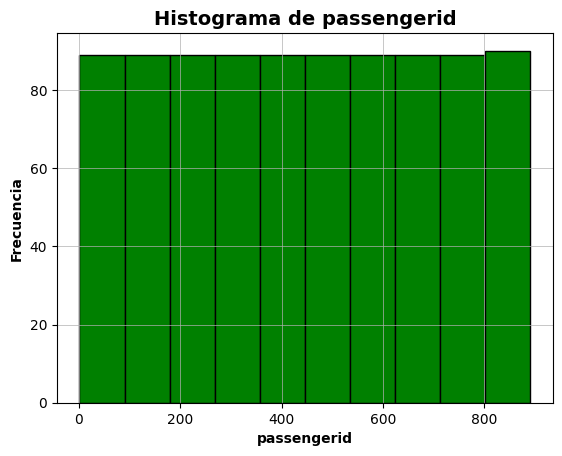

In [232]:
# Histograma muestra distribución de frecuencia de columna 'passengerid'
plt.hist(df["passengerid"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de passengerid', fontsize=14, fontweight='bold')
plt.xlabel('passengerid', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma con rango de datos entre 0 y alredor de 800, con frecuencias similares para cada grupo de valores, identificador con menos registros en valores altos.

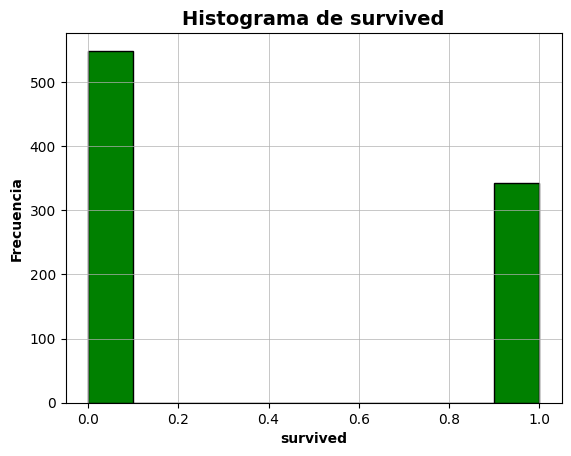

In [233]:
# Histograma muestra distribución de frecuencia de columna 'survived'
plt.hist(df["survived"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de survived', fontsize=14, fontweight='bold')
plt.xlabel('survived', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma con valores agrupados en rango de 0 y 1, con frecuencia más alta en valor 0, es decir mayor cantidad de valores en grupo de 0.

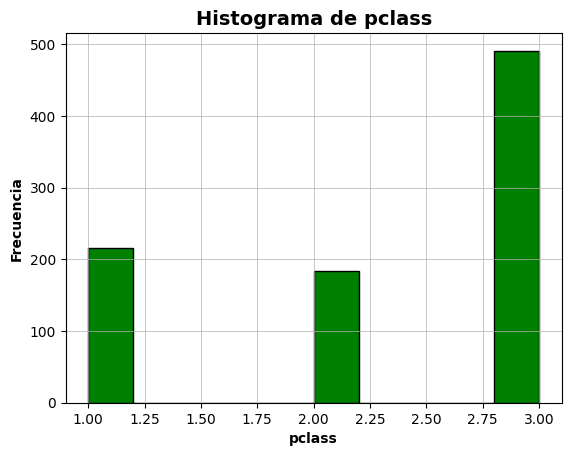

In [234]:
# Histograma muestra distribución de frecuencia de columna 'pclass'
plt.hist(df["pclass"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de pclass', fontsize=14, fontweight='bold')
plt.xlabel('pclass', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma con valores agrupados alrededor de 1.0 , 2.0 y 3.0, con frecuencia mas alta en valores entre , donde se distribuya la mayor cantidad de valores.

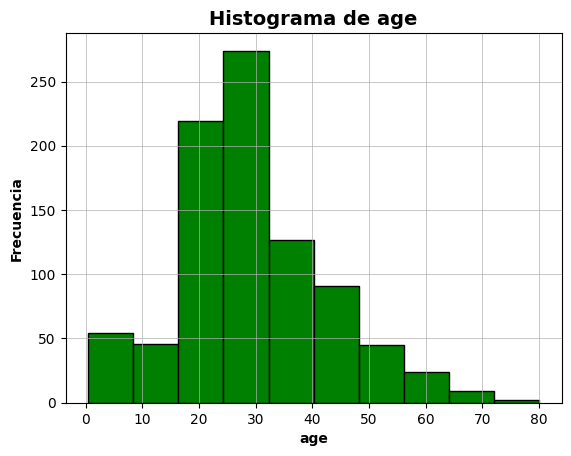

In [235]:
# Histograma muestra distribución de frecuencia de columna 'age'
plt.hist(df["age"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de age', fontsize=14, fontweight='bold')
plt.xlabel('age', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma muestra rango de edad de 0 a 80 años. Hay un alto entre 20 y 30 años, con una frecuencia muy alta que indica que este grupo de edad es el más frecuente en los datos. la máxima frecuencia supera las 250 personas en el grupo de 20 a 30 años. Hay muy pocos individuos en edades extremas. la distribución tiene una cola más larga hacia las edades mayores.


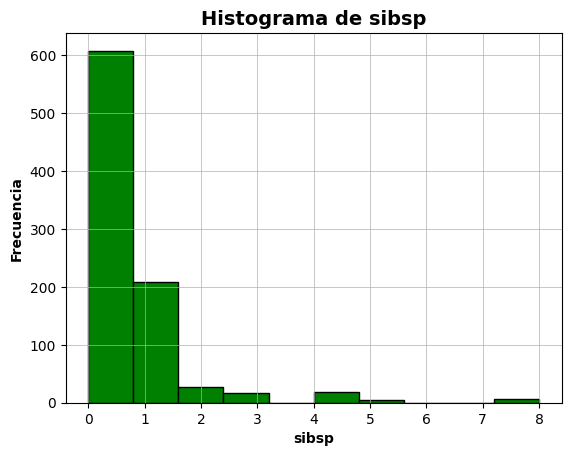

In [236]:
# Histograma muestra distribución de frecuencia de columna 'sibsp'
plt.hist(df["sibsp"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de sibsp', fontsize=14, fontweight='bold')
plt.xlabel('sibsp', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma sesgado a la izquierda, con rango de valores entre 0 y 8, con cola extendida hasta valor 8, La frecuencia más alta sobre 600, entre 0 a 1.

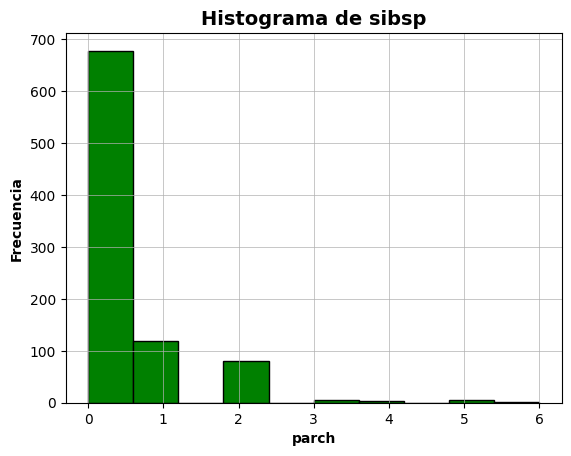

In [237]:
# Histograma muestra distribución de frecuencia de columna 'parch'
plt.hist(df["parch"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de sibsp', fontsize=14, fontweight='bold')
plt.xlabel('parch', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma sesgado hacia la izquierda, con valores entre 0 y 6, con cola extendida hacia la derecha hasta el valor 6, Frecuencia más alta sobre 600, entre 0 y 1.

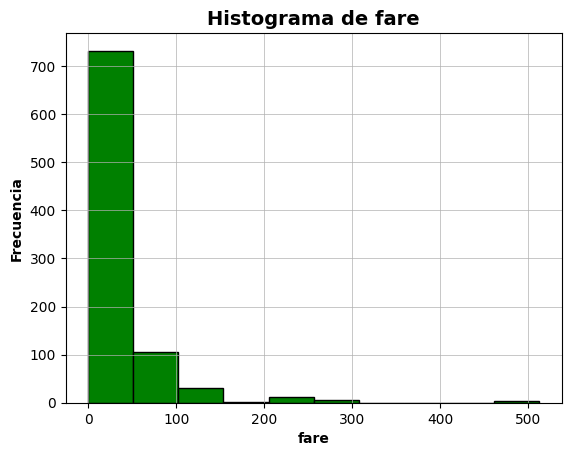

In [238]:
# Histograma muestra distribución de frecuencia de columna 'fare'
plt.hist(df["fare"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de fare', fontsize=14, fontweight='bold')
plt.xlabel('fare', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma sesgado hacia la izquierda, con valores entre 0 y 500, con cola extendida hacia la derecha hasta el valor 500, Frecuencia más alta sobre 700, entre 0 y 100.

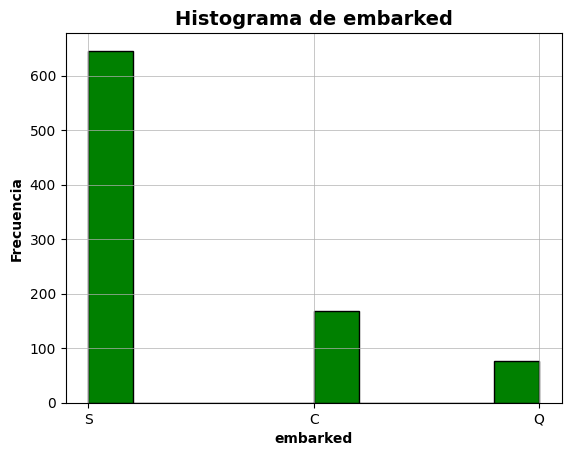

In [239]:
# Histograma muestra distribución de frecuencia de columna 'embarked'
plt.hist(df["embarked"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de embarked', fontsize=14, fontweight='bold')
plt.xlabel('embarked', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.grid(True, linewidth=0.5)
plt.show()

#### Histograma con valores distribuidos en barra S, C y Q, con frecuencua muy alta sobre 600 en grupo S. La mayor cantidad de pasajeros provenian del puerto S.

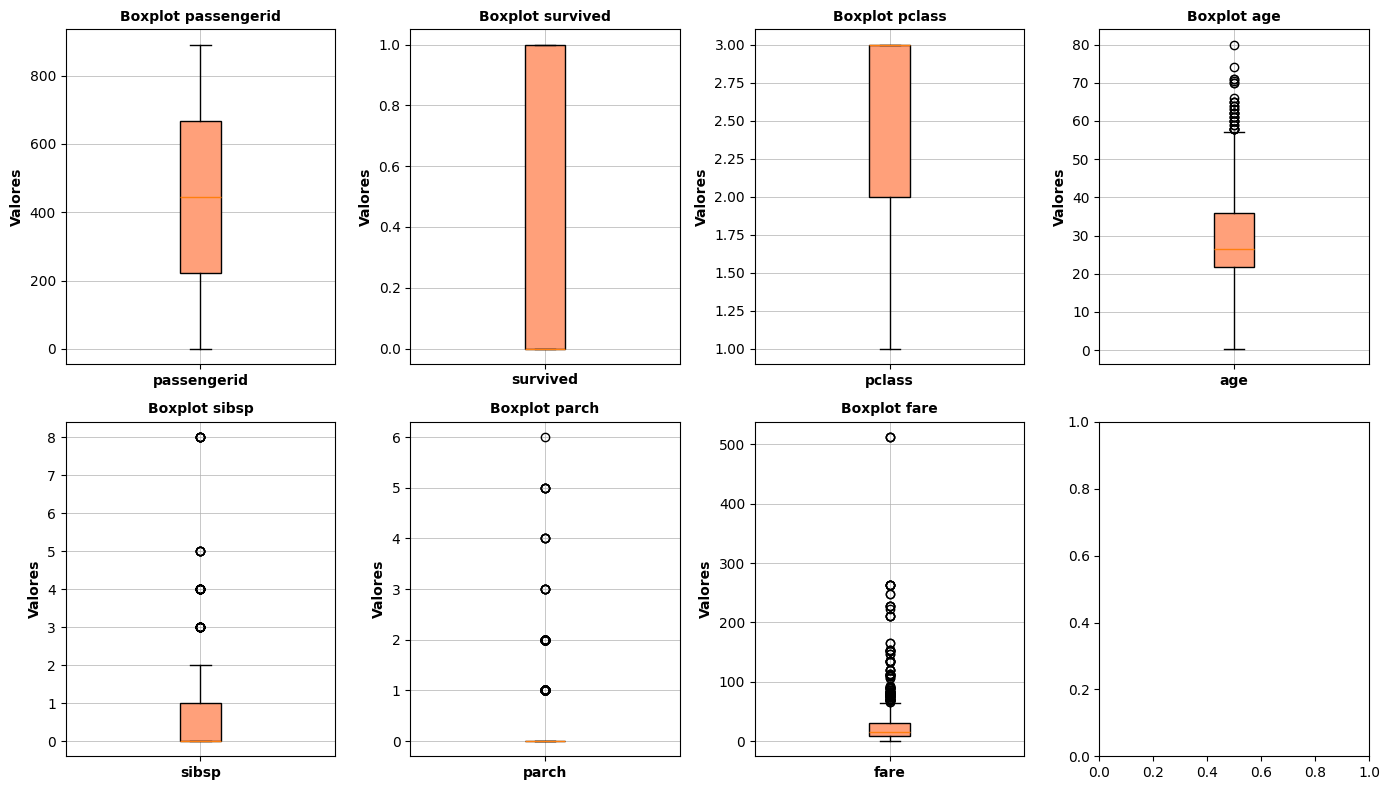

In [240]:
# # Crear la figura y los subplots.
fig, axs = plt.subplots(2, 4, figsize=(14, 8)) # Changed to 2x4 grid
# Se deja el array en una dimension para no usar indices con dos dimensiones
axs = axs.flatten()
# Columnas numéricas a graficar
numerical_cols = df.select_dtypes(include=['int64','float64'])
# Boxplot para las columnas numéricas
prop_caja = dict(facecolor='lightsalmon')
for i, col in enumerate(numerical_cols):
  axs[i].boxplot(df[col], patch_artist=True, boxprops=prop_caja)
  axs[i].set_title(f"Boxplot {col}", fontsize=10, fontweight='bold')
  axs[i].set_xticklabels([col], fontweight='bold')
  axs[i].set_ylabel("Valores", fontweight='bold')
  axs[i].grid(True, linewidth=0.5)

plt.tight_layout()
plt.show()

In [241]:
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [242]:
# Se veridfica outliers extremos de columnas
p_sup = 99   # Percentil superior más estricto
q_sup = np.percentile(df["age"], p_sup)
df[df["age"] >= q_sup]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,S


In [243]:
# Se veridfica outliers extremos de columnas
p_sup = 99   # Percentil superior más estricto
q_sup = np.percentile(df["sibsp"], p_sup)
df[df["sibsp"] >= q_sup]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
59,60,0,3,"Goodwin, Master. William Frederick",male,11.000000,5,2,CA 2144,46.90,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.000000,5,2,CA 2144,46.90,S
159,160,0,3,"Sage, Master. Thomas Henry",male,26.507589,8,2,CA. 2343,69.55,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,21.750000,8,2,CA. 2343,69.55,S
201,202,0,3,"Sage, Mr. Frederick",male,26.507589,8,2,CA. 2343,69.55,S
324,325,0,3,"Sage, Mr. George John Jr",male,26.507589,8,2,CA. 2343,69.55,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.000000,5,2,CA 2144,46.90,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.000000,5,2,CA 2144,46.90,S
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.000000,5,2,CA 2144,46.90,S
792,793,0,3,"Sage, Miss. Stella Anna",female,21.750000,8,2,CA. 2343,69.55,S


In [244]:
# Se veridfica outliers extremos de columnas
p_sup = 99   # Percentil superior más estricto
q_sup = np.percentile(df["parch"], p_sup)
df[df["parch"] >= q_sup]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,S
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,S
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,S
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,S
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,S
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9000,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,Q


In [245]:
# Se veridfica outliers extremos de columnas
p_sup = 99   # Percentil superior más estricto
q_sup = np.percentile(df["fare"], p_sup)
df[df["fare"] >= q_sup].round(2)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.33,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.38,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.00,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.33,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.33,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.38,C


#### Se verifica que existen varios valores atipicos en la muestra, se toma la decisión de no eliminarlos.

In [246]:
# Se reviza los datos con la correlaciones de Pearson

df_numericas = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = df_numericas.corr(method='pearson')
print(correlation_matrix)

             passengerid  survived    pclass       age     sibsp     parch  \
passengerid     1.000000 -0.005007 -0.035144  0.039636 -0.057527 -0.001652   
survived       -0.005007  1.000000 -0.338481 -0.067485 -0.035322  0.081629   
pclass         -0.035144 -0.338481  1.000000 -0.407015  0.083081  0.018443   
age             0.039636 -0.067485 -0.407015  1.000000 -0.251313 -0.180705   
sibsp          -0.057527 -0.035322  0.083081 -0.251313  1.000000  0.414838   
parch          -0.001652  0.081629  0.018443 -0.180705  0.414838  1.000000   
fare            0.012658  0.257307 -0.549500  0.118308  0.159651  0.216225   

                 fare  
passengerid  0.012658  
survived     0.257307  
pclass      -0.549500  
age          0.118308  
sibsp        0.159651  
parch        0.216225  
fare         1.000000  


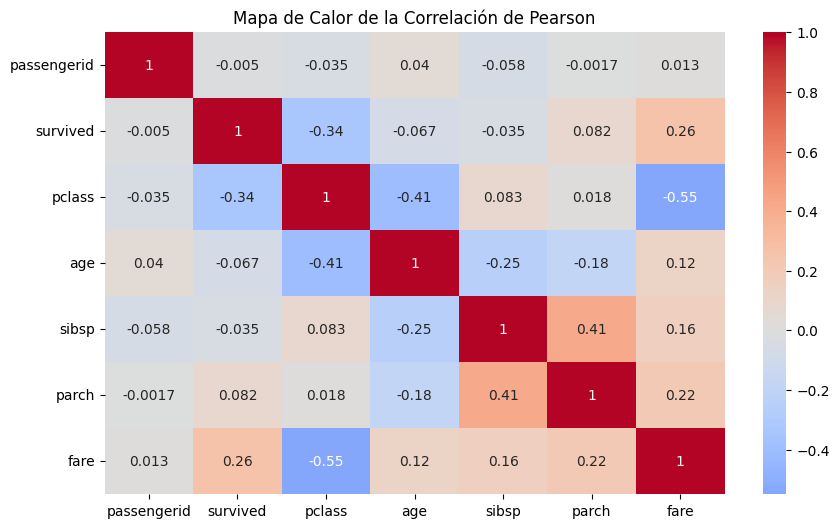

In [247]:
# Se Crea el  mapas de calor
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Mapa de Calor de la Correlación de Pearson")
plt.show()

#### Correlación negativa fuerte:
 * pclass y fare en -0.55, a menor clase, mayor tarifa y viceversa.

#### Correleación negativa moderada:
 * pclass y survided en -0.34, los pasajeros de clases más altas, tuvieron mayor probabilidad de sobrevivir.

#### Correlación positiva:
* sibsp y parch en 0.41, las familias tendian a viajar juntas, ejemplo ; padres con hijos o hermanos.

#### Correlacón negativa:
 * age y pclass en -0.41, los pasajeros en clases mas altas tendian a ser mayores,posible mayor capacidad economica en adultos.


 #### Preprocesamiento de Datos:

In [248]:
sexo = {"male":1, "female":0}
df["sex"] = df["sex"].map(sexo)

In [249]:
numerical_cols = ['passengerid', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']
categorical_cols = ['name', 'ticket', 'embarked']


In [250]:
X = df.drop(columns='survived')
y = df['survived']

In [251]:
# Dividir los datos en conjuntos de entrenamiento y prueba con variables numéricas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Modelo  Logistic Regression"

In [252]:
# Preprocesador.
preprocessor_lr = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_lr = Pipeline([
    ("preprocessing", preprocessor_lr),
    ("Logistic Regression", LogisticRegression())
])

In [253]:
# Entrenamiento.
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['passengerid', 'pclass',
                                                   'sex', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['name', 'ticket',
                                                   'embarked'])])),
                ('Logistic Regression', LogisticRegression())])

In [254]:
# Evaluación
# Predecir y evaluar
y_pred = pipeline_lr.predict(X_test)
y_proba = pipeline_lr.predict_proba(X_test)[:, 1]
print("\nLogistic Regression")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba):.4f}")


Logistic Regression
Accuracy: 0.83
Precision: 0.82
Recall: 0.76
F1 Score: 0.79
ROC AUC ScoreC: 0.8974


##### Modelo "KNN": KNeighborsClassifier.

In [255]:
# Preprocesador.
preprocessor_knn = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_knn = Pipeline([
    ("preprocessing", preprocessor_knn),
    ("Knn"          , KNeighborsClassifier(n_neighbors=5))
])

In [256]:
# Entrenamiento.
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['passengerid', 'pclass',
                                                   'sex', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['name', 'ticket',
                                                   'embarked'])])),
                ('Knn', KNeighborsClassifier())])

In [257]:
# Evaluación
# Predecir y evaluar
y_pred_knn = pipeline_knn.predict(X_test)
y_proba_knn = pipeline_knn.predict_proba(X_test)[:, 1]
print("\nKNeighborsClassifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_knn):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_knn):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_knn):.4f}")


KNeighborsClassifier
Accuracy: 0.80
Precision: 0.79
Recall: 0.72
F1 Score: 0.75
ROC AUC ScoreC: 0.8638


#### Modelo DecisionTreeClassifier

In [258]:
# Preprocesador.
preprocessor_tree = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_tree = Pipeline([
    ("preprocessing_tree", preprocessor_tree),
    ("Decision Tree"     , DecisionTreeClassifier(max_depth=3, random_state=42))
])

In [259]:
# Entrenamiento.
pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_tree',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['passengerid', 'pclass',
                                                   'sex', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['name', 'ticket',
                                                   'embarked'])])),
                ('Decision Tree',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [260]:
# Predecir y evaluar
y_pred_tree = pipeline_tree.predict(X_test)
y_proba_tree = pipeline_tree.predict_proba(X_test)[:, 1]
print("\nDecisionTreeClassifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_tree):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_tree):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_tree):.4f}")


DecisionTreeClassifier
Accuracy: 0.80
Precision: 0.80
Recall: 0.69
F1 Score: 0.74
ROC AUC ScoreC: 0.8463


Modelo  XGBClassifier

In [261]:
# Preprocesador.
preprocessor_xgb = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_xgb = Pipeline([
    ("preprocessing_xgb", preprocessor_xgb),
    ("XGBoost"          , xgb.XGBClassifier(n_estimators=100, random_state=42),)
])

In [262]:
# Entrenamiento.
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_xgb',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['passengerid', 'pclass',
                                                   'sex', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['name', 'ticket',
                                                   'embarked'])])),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               col...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [263]:
# Predecir y evaluar
y_pred_xgb = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
print("\nXGBClassifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_xgb):.4f}")


XGBClassifier
Accuracy: 0.79
Precision: 0.75
Recall: 0.73
F1 Score: 0.74
ROC AUC ScoreC: 0.8649


#### Modelo LGBMClassifier()

In [264]:
# Preprocesador.
preprocessor_lgb = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_lgb = Pipeline([
    ("preprocessing_lgb", preprocessor_lgb),
    ("LGBoost"          , lgb.LGBMClassifier(objective='binary'))
])

In [265]:
# Entrenamiento.
pipeline_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Pipeline(steps=[('preprocessing_lgb',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['passengerid', 'pclass',
                                                   'sex', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['name', 'ticket',
                                                   'embarked'])])),
                ('LGBoost', LGBMClassifier(objective='binary'))])

In [266]:
# Predecir y evaluar
y_pred_lgb = pipeline_lgb.predict(X_test)
y_proba_lgb = pipeline_lgb.predict_proba(X_test)[:, 1]
print("\nLGBMClassifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_lgb):.4f}")


LGBMClassifier
Accuracy: 0.82
Precision: 0.77
Recall: 0.78
F1 Score: 0.78
ROC AUC ScoreC: 0.8730


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Evaluación inicial de los modelos

In [267]:
print(f"\nLogistic Regression       Accuracy: {accuracy_score(y_test, y_pred):.2f} Precision: {precision_score(y_test, y_pred):.2f} Recall: {recall_score(y_test, y_pred):.2f} F1 Score: {f1_score(y_test, y_pred):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"KNeighborsClassifier      Accuracy: {accuracy_score(y_test, y_pred_knn):.2f} Precision: {precision_score(y_test, y_pred_knn):.2f} Recall: {recall_score(y_test, y_pred_knn):.2f} F1 Score: {f1_score(y_test, y_pred_knn):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_knn):.4f}")
print(f"DecisionTreeClassifier    Accuracy: {accuracy_score(y_test, y_pred_tree):.2f} Precision: {precision_score(y_test, y_pred_tree):.2f} Recall: {recall_score(y_test, y_pred_tree):.2f} F1 Score: {f1_score(y_test, y_pred_tree):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_tree):.4f}")
print(f"XGBClassifier             Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f} Precision: {precision_score(y_test, y_pred_xgb):.2f} Recall: {recall_score(y_test, y_pred_xgb):.2f} F1 Score: {f1_score(y_test, y_pred_xgb):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"LGBMClassifier            Accuracy: {accuracy_score(y_test, y_pred_lgb):.2f} Precision: {precision_score(y_test, y_pred_lgb):.2f} Recall: {recall_score(y_test, y_pred_lgb):.2f} F1 Score: {f1_score(y_test, y_pred_lgb):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_lgb):.4f}")


Logistic Regression       Accuracy: 0.83 Precision: 0.82 Recall: 0.76 F1 Score: 0.79 ROC AUC ScoreC: 0.8974
KNeighborsClassifier      Accuracy: 0.80 Precision: 0.79 Recall: 0.72 F1 Score: 0.75 ROC AUC ScoreC: 0.8638
DecisionTreeClassifier    Accuracy: 0.80 Precision: 0.80 Recall: 0.69 F1 Score: 0.74 ROC AUC ScoreC: 0.8463
XGBClassifier             Accuracy: 0.79 Precision: 0.75 Recall: 0.73 F1 Score: 0.74 ROC AUC ScoreC: 0.8649
LGBMClassifier            Accuracy: 0.82 Precision: 0.77 Recall: 0.78 F1 Score: 0.78 ROC AUC ScoreC: 0.8730


#### Logistic Regression es el mejor modelo inicial en general, con mayor accuracy de 0.83, mayor precision de 0.82, mejor F1-score con 0.79 y mejor Roc Auc Score con 0.89.

#### Logistic Regression optimización con GridSearch.

In [268]:
# Preprocesador.
preprocessor_lr1 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_lr1 = Pipeline([
    ("preprocessing", preprocessor_lr1),
    ("Logistic Regression1", LogisticRegression())
])

In [269]:
# Parametros de Gridsearch
param_grid_lr1 = {
    'Logistic Regression1__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algoritmo de optimización
    'Logistic Regression1__max_iter': [100, 200, 500],  # Número máximo de iteraciones
    'Logistic Regression1__class_weight': [None, 'balanced']  # Para manejar clases desbalanceadas
   }
# Configurar GridSearchCV
lr1_grid = GridSearchCV(estimator=pipeline_lr1, param_grid=param_grid_lr1, scoring='accuracy', cv=5, n_jobs=-1, verbose=3, refit=True, return_train_score=True
)
lr1_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['passengerid',
                                                                          'pclass',
                                                                          'sex',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['name',
                                                                          'ticket',
                                                                          'embarked'])])),
                                       ('Logistic Regression1',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'Logistic Regression1__class_weight': [None,
                                                                'balanced'],
                         'Logistic Regression1__max_iter': [100, 200, 500],
                         'Logistic Regression1__solver': ['newton-cg', 'lbfgs',
                                                          'liblinear', 'sag',
                                                          'saga']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [270]:
# Predecir y evaluar
lr1_best = lr1_grid.best_estimator_
y_pred_lr1 = lr1_best.predict(X_test)
y_proba_lr1 = lr1_grid.predict_proba(X_test)[:, 1]
print("\nLogistic Regression optimizado con Gridsearch")
print("Mejores parámetros:", lr1_grid.best_params_)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr1):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr1):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr1):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr1):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_lr1):.4f}")



Logistic Regression optimizado con Gridsearch
Mejores parámetros: {'Logistic Regression1__class_weight': None, 'Logistic Regression1__max_iter': 100, 'Logistic Regression1__solver': 'newton-cg'}

Accuracy: 0.83
Precision: 0.82
Recall: 0.76
F1 Score: 0.79
ROC AUC ScoreC: 0.8976


#### KNeighborsClassifier optimización con GridSearch.

In [271]:
# Preprocesador.
preprocessor_knn1 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_knn1 = Pipeline([
    ("preprocessing", preprocessor_knn1),
    ("knn1"         , KNeighborsClassifier())
])

In [272]:
# Parametros de Gridsearch
param_grid_knn1 = {
    'knn1__n_neighbors': list(range(1, 31)),  # Valores de k desde 1 a 30
    'knn1__weights': ['uniform', 'distance'],  # Ponderación por distancia o uniforme
    'knn1__metric': ['euclidean', 'manhattan', 'minkowski'],  # Métricas de distancia
    }
# Configurar GridSearchCV
knn1_grid = GridSearchCV(estimator=pipeline_knn1, param_grid=param_grid_knn1, scoring='accuracy', cv=5, n_jobs=-1, refit=True, return_train_score=True
)
knn1_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['passengerid',
                                                                          'pclass',
                                                                          'sex',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['name',
                                                                          'ticket',
                                                                          'embarked'])])),
                                       ('knn1', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn1__metric': ['euclidean', 'manhattan',
                                          'minkowski'],
                         'knn1__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30],
                         'knn1__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [273]:
# Predecir y evaluar
knn1_best = knn1_grid.best_estimator_
y_pred_knn1 = knn1_best.predict(X_test)
y_proba_knn1 = knn1_grid.predict_proba(X_test)[:, 1]
print("\nKNeighborsClassifier optimizado con Gridsearch")
print("Mejores parámetros:", knn1_grid.best_params_)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_knn1):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_knn1):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_knn1):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn1):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_knn1):.4f}")



KNeighborsClassifier optimizado con Gridsearch
Mejores parámetros: {'knn1__metric': 'manhattan', 'knn1__n_neighbors': 15, 'knn1__weights': 'distance'}

Accuracy: 0.81
Precision: 0.82
Recall: 0.69
F1 Score: 0.75
ROC AUC ScoreC: 0.8968


 #### DecisionTreeClassifier optimización con GridSearch.

In [274]:
# Preprocesador.
preprocessor_tree1 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_tree1 = Pipeline([
    ("preprocessing_tree1", preprocessor_tree1),
    ("Decision Tree1"     , DecisionTreeClassifier())
])

In [275]:
# Parametros de Gridsearch
param_grid_tree1 = {
    'Decision Tree1__splitter': ['best', 'random'],  # Estrategia para elegir división
    'Decision Tree1__max_depth': [None, 3, 5, 7, 10, 15, 20, 25],  # Profundidad máxima del árbol
    'Decision Tree1__min_samples_split': [2, 5, 10, 15, 20],  # Mínimo muestras para dividir un nodo
   }
# Configurar GridSearchCV
tree1_grid = GridSearchCV(estimator=pipeline_tree1, param_grid=param_grid_tree1, scoring='accuracy', cv=5, n_jobs=-1, refit=True, return_train_score=True
)
tree1_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_tree1',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['passengerid',
                                                                          'pclass',
                                                                          'sex',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['name',
                                                                          'ticket',
                                                                          'embarked'])])),
                                       ('Decision Tree1',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'Decision Tree1__max_depth': [None, 3, 5, 7, 10, 15,
                                                       20, 25],
                         'Decision Tree1__min_samples_split': [2, 5, 10, 15,
                                                               20],
                         'Decision Tree1__splitter': ['best', 'random']},
             return_train_score=True, scoring='accuracy')

In [276]:
# Predecir y evaluar
tree1_best = tree1_grid.best_estimator_
y_pred_tree1 = tree1_best.predict(X_test)
y_proba_tree1 = tree1_grid.predict_proba(X_test)[:, 1]
print("\nDecisionTreeClassifier optimizado con Gridsearch")
print("Mejores parámetros:", tree1_grid.best_params_)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_tree1):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tree1):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_tree1):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_tree1):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_tree1):.4f}")



DecisionTreeClassifier optimizado con Gridsearch
Mejores parámetros: {'Decision Tree1__max_depth': 10, 'Decision Tree1__min_samples_split': 5, 'Decision Tree1__splitter': 'random'}

Accuracy: 0.81
Precision: 0.80
Recall: 0.72
F1 Score: 0.76
ROC AUC ScoreC: 0.8602


####  XGBClassifier optimización con GridSearch.

In [277]:
# Preprocesador.
preprocessor_xgb1 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_xgb1 = Pipeline([
    ("preprocessing_xgb1", preprocessor_xgb1),
    ("XGB1"              , xgb.XGBClassifier(n_estimators=100, random_state=42),)
])

In [278]:
# Parametros de Gridsearch
param_grid_xgb1 = {
    'XGB1__n_estimators': [100, 200, 300],
    'XGB1__learning_rate': [0.01, 0.1, 0.2],
    'XGB1__max_depth': [3, 5, 7],
    'XGB1__subsample': [0.8, 1.0],
    'XGB1__colsample_bytree': [0.8, 1.0]
}
# Configurar GridSearchCV
xgb1_grid = GridSearchCV(estimator=pipeline_xgb1, param_grid=param_grid_xgb1, scoring='accuracy', cv=5, n_jobs=-1, refit=True, return_train_score=True
)
xgb1_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_xgb1',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['passengerid',
                                                                          'pclass',
                                                                          'sex',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['name',
                                                                          'ticket',
                                                                          'embarked'])])),
                                       ('XGB1',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'XGB1__colsample_bytree': [0.8, 1.0],
                         'XGB1__learning_rate': [0.01, 0.1, 0.2],
                         'XGB1__max_depth': [3, 5, 7],
                         'XGB1__n_estimators': [100, 200, 300],
                         'XGB1__subsample': [0.8, 1.0]},
             return_train_score=True, scoring='accuracy')

In [279]:
# Predecir y evaluar
xgb1_best = xgb1_grid.best_estimator_
y_pred_xgb1 = xgb1_best.predict(X_test)
y_proba_xgb1 = xgb1_grid.predict_proba(X_test)[:, 1]
print("\nXGBClassifier optimizado con Gridsearch")
print("Mejores parámetros:", xgb1_grid.best_params_)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_xgb1):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb1):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb1):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb1):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_xgb1):.4f}")



XGBClassifier optimizado con Gridsearch
Mejores parámetros: {'XGB1__colsample_bytree': 1.0, 'XGB1__learning_rate': 0.1, 'XGB1__max_depth': 3, 'XGB1__n_estimators': 100, 'XGB1__subsample': 1.0}

Accuracy: 0.79
Precision: 0.79
Recall: 0.68
F1 Score: 0.73
ROC AUC ScoreC: 0.8741


####  LGBMClassifier optimización con GridSearch.

In [280]:
# Preprocesador.
preprocessor_lgb1 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Modelo.
pipeline_lgb1 = Pipeline([
    ("preprocessing_lgb1", preprocessor_lgb1),
    ("LGBM1"              , lgb.LGBMClassifier(objective='binary'))
])

In [281]:
# Parametros de Gridsearch
param_grid_lgb1 = {
    'LGBM1__learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'LGBM1__n_estimators': [50, 100, 200],      # Número de árboles
    'LGBM1__num_leaves': [15, 31, 63],          # Número máximo de hojas por árbol
    'LGBM1__max_depth': [1, 5, 10],             # Profundidad máxima
   }
# Configurar GridSearchCV
lgb1_grid = GridSearchCV(estimator=pipeline_lgb1, param_grid=param_grid_lgb1, scoring='accuracy', cv=5, n_jobs=-1, refit=True, return_train_score=True
)
lgb1_grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_lgb1',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['passengerid',
                                                                          'pclass',
                                                                          'sex',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['name',
                                                                          'ticket',
                                                                          'embarked'])])),
                                       ('LGBM1',
                                        LGBMClassifier(objective='binary'))]),
             n_jobs=-1,
             param_grid={'LGBM1__learning_rate': [0.01, 0.05, 0.1],
                         'LGBM1__max_depth': [1, 5, 10],
                         'LGBM1__n_estimators': [50, 100, 200],
                         'LGBM1__num_leaves': [15, 31, 63]},
             return_train_score=True, scoring='accuracy')

In [282]:
# Predecir y evaluar
lgb1_best = lgb1_grid.best_estimator_
y_pred_lgb1 = lgb1_best.predict(X_test)
y_proba_lgb1 = lgb1_grid.predict_proba(X_test)[:, 1]
print("\nLGBMClassifier optimizado con Gridsearch")
print("Mejores parámetros:", lgb1_grid.best_params_)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lgb1):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb1):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb1):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb1):.2f}")
print(f"ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_lgb1):.4f}")



LGBMClassifier optimizado con Gridsearch
Mejores parámetros: {'LGBM1__learning_rate': 0.05, 'LGBM1__max_depth': 10, 'LGBM1__n_estimators': 100, 'LGBM1__num_leaves': 31}

Accuracy: 0.81
Precision: 0.79
Recall: 0.74
F1 Score: 0.76
ROC AUC ScoreC: 0.8888


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [283]:
print(f"\nLogistic Regression Optimizado con Gridsearch      Accuracy: {accuracy_score(y_test, y_pred_lr1):.2f} Precision: {precision_score(y_test, y_pred_lr1):.2f} Recall: {recall_score(y_test, y_pred_lr1):.2f} F1 Score: {f1_score(y_test, y_pred_lr1):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_lr1):.4f}")
print(f"KNeighborsClassifier Optimizado con Gridsearch     Accuracy: {accuracy_score(y_test, y_pred_knn1):.2f} Precision: {precision_score(y_test, y_pred_knn1):.2f} Recall: {recall_score(y_test, y_pred_knn1):.2f} F1 Score: {f1_score(y_test, y_pred_knn1):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_knn1):.4f}")
print(f"DecisionTreeClassifier Optimizado con Gridsearch   Accuracy: {accuracy_score(y_test, y_pred_tree1):.2f} Precision: {precision_score(y_test, y_pred_tree1):.2f} Recall: {recall_score(y_test, y_pred_tree1):.2f} F1 Score: {f1_score(y_test, y_pred_tree1):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_tree1):.4f}")
print(f"XGBClassifier Optimizado con Gridsearch            Accuracy: {accuracy_score(y_test, y_pred_xgb1):.2f} Precision: {precision_score(y_test, y_pred_xgb1):.2f} Recall: {recall_score(y_test, y_pred_xgb1):.2f} F1 Score: {f1_score(y_test, y_pred_xgb1):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_xgb1):.4f}")
print(f"LGBMClassifier Optimizado con Gridsearch           Accuracy: {accuracy_score(y_test, y_pred_lgb1):.2f} Precision: {precision_score(y_test, y_pred_lgb1):.2f} Recall: {recall_score(y_test, y_pred_lgb1):.2f} F1 Score: {f1_score(y_test, y_pred_lgb1):.2f} ROC AUC ScoreC: {roc_auc_score(y_test, y_proba_lgb1):.4f}")


Logistic Regression Optimizado con Gridsearch      Accuracy: 0.83 Precision: 0.82 Recall: 0.76 F1 Score: 0.79 ROC AUC ScoreC: 0.8976
KNeighborsClassifier Optimizado con Gridsearch     Accuracy: 0.81 Precision: 0.82 Recall: 0.69 F1 Score: 0.75 ROC AUC ScoreC: 0.8968
DecisionTreeClassifier Optimizado con Gridsearch   Accuracy: 0.81 Precision: 0.80 Recall: 0.72 F1 Score: 0.76 ROC AUC ScoreC: 0.8602
XGBClassifier Optimizado con Gridsearch            Accuracy: 0.79 Precision: 0.79 Recall: 0.68 F1 Score: 0.73 ROC AUC ScoreC: 0.8741
LGBMClassifier Optimizado con Gridsearch           Accuracy: 0.81 Precision: 0.79 Recall: 0.74 F1 Score: 0.76 ROC AUC ScoreC: 0.8888


#### Mejor Accuracy : LogicticRegression 0.83
#### Mejor Precision: KNeighborsClassifier y LogisticRegression 0.82
#### Mejor Recall   : Logistic Regression 0.76
#### Mejor F1 score : LogicticRegression 0.79
#### Mejor Roc Auc  : LogicticRegression 0.897

#### Mejor Modelo en general

* LogicticRegression  obtuvo el mejor rendimiento en la mayoria de las metricas.

#### Dado los resultados,  LogicticRegression parece ser el mejor modelo para este problema especifico, seguido de cerca por KneighbordsClassifier y LGBMClassifier. La elección final dependera de considerar el rendimiento computacional.